In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
path = Path('/app/data/raw/2023.05.24 OGW database.xlsx')
assert path.exists()

In [5]:
# dbcp.extract.eip_infrastructure.extract(path)
# vendor the extract function so this notebook can be easily rerun in the future without maintenance
def _convert_object_to_string_dtypes(df: pd.DataFrame) -> None:
    strings = df.select_dtypes("object")
    df.loc[:, list(strings.columns)] = strings.astype(pd.StringDtype())


def _downcast_ints(df: pd.DataFrame) -> None:
    ints = df.select_dtypes(np.int64)
    for col in ints.columns:
        ser = df.loc[:, col]
        assert (
            ser.ge(0).fillna(True).all()
        )  # didn't implement this for negative numbers
        assert np.all((ser.values >> 32) == 0)  # check for high bits
        df.loc[:, col] = ser.astype(pd.Int32Dtype())


def extract(path: Path) -> dict[str, pd.DataFrame]:
    """Read EIP excel database.

    Args:
        path (Path): filepath

    Returns:
        Dict[str, pd.DataFrame]: output dictionary of dataframes
    """
    sheets_to_read = [
        "Facility",
        # 'Company',
        "Project",
        "Air Construction",  # permit status is key to identifying actionable projects
        # 'Pipelines',
        # 'NGA',
        # 'NAICS',
        # 'CWA-NPDES',
        # 'CWA Wetland',
        # 'Air Operating',
        # 'Glossary',  # useful for data dictionary
        # 'Data Sources',
        # 'Map Layers',
        # 'Other Permits',
        # 'Test Collection',
        # 'Featured Facility Descriptors',
        # 'MARAD',
        # 'TEST',
        # 'Pipeline Digitization',
    ]
    raw_dfs = pd.read_excel(path, sheet_name=sheets_to_read)
    rename_dict = {
        "Facility": "eip_facilities",
        "Project": "eip_projects",
        "Air Construction": "eip_air_constr_permits",
    }
    raw_dfs = {rename_dict[key]: df for key, df in raw_dfs.items()}
    for df in raw_dfs.values():
        _convert_object_to_string_dtypes(df)
        _downcast_ints(df)

    return raw_dfs

proj = extract(path)['eip_projects']

In [6]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [7]:
proj.shape

(938, 40)

# Cleaning
## Projects Cleaning
- [x] Accuracy
- [x] Atomicity
- [ ] Consistency
- [x] Completeness
- [x] Uniformity
- [x] Validity
    - [x] Range Validation
    - [x] Uniqueness Validation
    - [x] Set Membership Validation
    - [x] Type Validation
    - [x] Cross-Field Validation

### Accuracy
The biggest accuracy risks for this dataset are probably 1) bad reporting to the EPA (would take a huge research effort to double check that) and 2) transcription errors by EIP between the PDFs and the database. I'll do a little spot check to guard againt the second.

Results: I only checked 3 facilities but still managed to find conflicting information about CO2e numbers 😕

In [8]:
proj.sample(3, random_state=42)

,id,name,created_on,modified_on,Facility (ID),Facility,CCS (ID),CCS,Project Description,Classification,Industry Sector,Project Type,Product Type,Air Construction (ID),Air Construction,Air Operating (ID),Air Operating,NGA (ID),NGA,MARAD (ID),MARAD,Other Permits (ID),Other Permits,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs),Total Wetlands Affected Temporarily (acres),Total Wetlands Affected Permanently (acres),Detailed Permitting History,Emission Accounting Notes,Construction Status Last Updated,Operating Status,Actual or Expected Completion Year,Project Cost (million $),Number of Jobs Promised,Target List
70,2794,Clear Lake Methanol Plant - New Methanol Unit,2021-05-24T22:56:59.087382,2021-11-05T14:51:46.233965,806.0,Celanese Clear Lake Plant[806],NaN,<NA>,Construction of a new methanol unit at an exis...,Expansion,Petrochemicals and Plastics,Methanol Plant,<NA>,"1926, 1948","103626 and PSDTX1296[1926], GHGPSDTX25 (PSD-TX...",<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,535218.0,40.39,59.50,83.62,8.34,612.50,<NA>,<NA>,NaN,<NA>,"PSD-TX-1296-GHG (issued 12/12/2013), PSDTX1296...",<NA>,Operating,2015,NaN,<NA>,<NA>
331,3065,Sanderson Gas Plant - Initial Construction,2021-05-24T22:56:59.087382,2022-05-02T17:20:11.050561,1050.0,Sanderson Gas Plant[1050],NaN,<NA>,Construction of a new 250 million cubic feet p...,New,Natural Gas,Gas Processing Plant,<NA>,2202,PTC20021[2202],<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,137328.0,0.69,91.71,41.30,0.52,90.46,9.48,<NA>,NaN,<NA>,Construction began in May 2020 and took 8 mont...,<NA>,Operating,2021,NaN,<NA>,<NA>
858,6006,Dyno Nobel - New Cogeneration Boiler,2023-01-17T16:09:55.502604,2023-02-13T19:24:12.307004,746.0,Dyno Nobel Ammonia Production Facility[746],NaN,<NA>,Dyno Nobel proposes to install and operate a n...,Expansion,Synthetic Fertilizers,Associated Electricity Generation,<NA>,"6007, 5292","1340-00352-V9[6007], PSD-LA-768 (M7) and 1340-...",<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,7.30,36.38,8.23,1.09,72.77,<NA>,<NA>,NaN,<NA>,CM 1/17/23: emissions from 1/10 public notice,2023-01-17,Pre-construction,Unknown,NaN,<NA>,<NA>


Clear Lake Methanol Plant - New Methanol Unit: [permit](https://api.oilandgaswatch.org/d/85/58/8558190dca204073ab0cc0a19225af76.1636124503.pdf) confirmed GHG figure in most recent permit and others in a [previous draft document](https://api.oilandgaswatch.org/d/6c/66/6c66b7c16c28463aa88ddc759ae2d7dc.1660831676.pdf).

Skipped Sanderson b/c already operating

Dyno Nobel - New Cogeneration Boiler: confirmed via [permit](https://api.oilandgaswatch.org/d/04/9c/049c34df7f954514a1a605e956a94fb0.1673972782.pdf)

### Atomicity
By inspection I see that all the ID and associated name fields can contain multiple values. I'll only worry about Facility IDs and Air Construction Permit IDs.

On a related note, both the facilities table and the project table have a column linking the two. I'll have to combine them to get a complete association entity table.

### Completeness
For this purpose, I'll limit the scope of 'completeness' to only look at missing values within the data. Ensuring projects are in the dataset at all is, unfortunately, beyond the scope of this project.

We are not interested in already-operating projects, so I'll remove those and assess completeness based on the remaining subset.

Notable missing values and lack of missing values:
* all projects are linked to a facility ID!
* all projects have an operating status
* 235 (45%) are missing Air Construction Permit IDs. Likely because many of these projects are too new to have gone through the permitting process.
* 260 (50%) are missing CO2e estimates. Same newness reason.

For evidence of the "too new to have a permit" hypothesis, see that the criteria pollutants with "Announced" status are almost completely null.

In [9]:
len(proj)

938

In [10]:
proj['Operating Status'].value_counts()

Operating              422
Pre-construction       209
Announced              162
Under construction      54
Canceled                39
Partially operating     27
On hold                 21
Commissioning            2
Unknown                  1
Name: Operating Status, dtype: Int64

In [12]:
proj.loc[proj['Operating Status'].ne('Operating'),:].isna().agg(['mean', 'sum']).T

,mean,sum
id,0.000000,0.0
name,0.000000,0.0
created_on,0.000000,0.0
modified_on,0.000000,0.0
Facility (ID),0.001942,1.0
Facility,0.001942,1.0
CCS (ID),0.965049,497.0
CCS,0.887379,457.0
Project Description,0.003883,2.0
Classification,0.003883,2.0


In [13]:
proj['Greenhouse Gases (CO2e)'].isna().groupby(proj['Operating Status']).agg(['mean', 'sum', 'size'])

,mean,sum,size
Operating Status,,,
Announced,0.981481,159,162
Canceled,0.102564,4,39
Commissioning,0.500000,1,2
On hold,0.190476,4,21
Operating,0.210900,89,422
Partially operating,0.222222,6,27
Pre-construction,0.311005,65,209
Under construction,0.370370,20,54
Unknown,1.000000,1,1


### Consistency - defer
Defer until I've cleaned the related datasets
### Uniformity
Important columns to check consistent representation:
* ID fields (check consistent array delimiters)
* all the emissions - check metric vs short tons [update: too similar to differentiate]

Secondary importance:
* modified_on
* project cost (supposed to be in millions $)
* jobs promised has inconsistent formatting/delimiters

#### ID Fields
Want to check for consistent array delimiters.

In [15]:
# exclude ID cols with numeric types (no arrays present)
id_cols = [col for col in proj.columns if '(ID)' in col and pd.api.types.is_string_dtype(proj[col])]
id_cols

['Air Construction (ID)',
 'Air Operating (ID)',
 'NGA (ID)',
 'Other Permits (ID)']

In [16]:
# mandatory opening pattern, optional delimiter, optional repeating pattern, optional closing pattern, mandatory end of line
array_pattern = r'(?:\d{3,5})(?:, ?)?(?:\d{3,5}, ?)*(?:\d{3,5})?$'

In [17]:
test_case = pd.Series([
    '1234',
    '1234,567',
    '1234, 567',
    '12345, 678, 9012',
    '1234\t5678', # tab is bad, no comma
    '12, 3456', # too short
    '1234    5678', # too many spaces, no comma
])
pd.concat([test_case, test_case.str.match(array_pattern)], axis=1)

,0,1
0,1234,True
1,"1234,567",True
2,"1234, 567",True
3,"12345, 678, 9012",True
4,1234\t5678,False
5,"12, 3456",False
6,1234 5678,False


In [18]:
# all pass the formatting test
for col in id_cols:
    assert proj[col].str.match(array_pattern).all()

#### Emissions
Check metric vs short tons

Edit: difference is only a factor of 0.907 so I won't be able to tell the difference. Within the noise.

<AxesSubplot: ylabel='Frequency'>

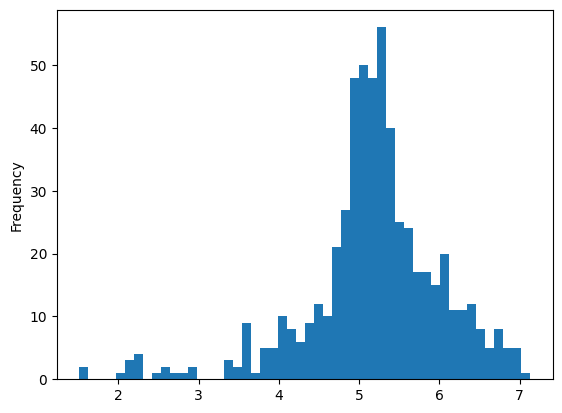

In [19]:
proj['Greenhouse Gases (CO2e)'].replace(0, np.nan).transform(np.log10).plot.hist(bins=50)

#### Date Modified

In [20]:
# to_datetime works on all values present
timestamps = pd.to_datetime(proj['modified_on'])
timestamps.dtypes, timestamps.isna().sum()

(dtype('<M8[ns]'), 0)

#### Jobs
Check array delimiter, naming, and order.

* Array delimiter: can be `,` or `;` or none
* naming: `temporary`, `permanent`, `full-time`, `construction`, `operating` and none given
* order: not consistent. Needs a parser.

In [22]:
# only 156 (17%) have jobs numbers
proj['Number of Jobs Promised'].notna().agg(['mean', 'sum'])

mean      0.166311
sum     156.000000
Name: Number of Jobs Promised, dtype: float64

In [23]:
jobs = proj['Number of Jobs Promised'].dropna()

**What special characters are present?**

In [24]:
from functools import reduce
reduce(set.union, [set(item) for item in jobs.str.replace('\d+|\w+|\s+', '', regex=True).to_list()])

{'(', ')', ',', '-', ';', '>'}

In [25]:
# not a delimiter
jobs[jobs.str.contains('>')]

538    1,000-1,500 construction jobs, >100 permanent ...
Name: Number of Jobs Promised, dtype: string

In [26]:
# not an array delimiter. It is a range delimiter
jobs[jobs.str.contains('-')]

39     200 construction jobs; 40 full-time jobs (for ...
73            800-2000 temporary jobs; 65 permanent jobs
134                   1500-2000 temporary; 200 full-time
247                             1500-2000 temporary jobs
260                    3,500 construction; 500 full-time
282          400 full-time jobs; 6,000 construction jobs
293                   1400-6000 temporary; 250 permanent
296                                                35-50
337                       40-260 temporary; 28 permanent
515                                                10-20
528                      350-520 temporary; 12 permanent
538    1,000-1,500 construction jobs, >100 permanent ...
541                                    150-200 permanent
563                        70-110 temporary; 2 permanent
628                   200-300 temporary, 10-20 permanent
648                                   240 full-time jobs
664         500-800 construction jobs; 35 permanent jobs
740                            

In [27]:
# not a delimiter
jobs[jobs.str.contains('\(|\)')]

39    200 construction jobs; 40 full-time jobs (for ...
Name: Number of Jobs Promised, dtype: string

**What job types are present?**

In [28]:
jobs.str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       50
temporary       44
jobs            27
construction    24
full             9
time             9
if               2
operating        2
built            2
in               2
County           2
Project          1
for              1
the              1
entire           1
BWTX             1
SMP              1
Calhoun          1
pipeline         1
during           1
including        1
Unknown          1
job              1
peak             1
Howard           1
Name: 0, dtype: Int64

In [29]:
# repeat but without that long parenthetical
jobs.str.replace('\(.+\)', '', regex=True).str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       50
temporary       44
jobs            27
construction    23
full             9
time             9
if               2
in               2
operating        2
County           2
built            2
Calhoun          1
Unknown          1
job              1
peak             1
during           1
Howard           1
Name: 0, dtype: Int64

I think `permanent`, `full-time` and `operating` are equivalent. And `temporary` == `construction`. And `Unkown` is Null.

### Range Validation
Check IDs, Emissions, Cost, Jobs, expected completion year
#### Emissions
Kind of hard to interpret, but no outrageous smoking guns

In [30]:
emission_cols = [
    'Greenhouse Gases (CO2e)',
    'Particulate Matter (PM2.5)',
    'Nitrogen Oxides (NOx)',
    'Volatile Organic Compounds (VOC)',
    'Sulfur Dioxide (SO2)',
    'Carbon Monoxide (CO)',
    'Hazardous Air Pollutants (HAPs)',
]

In [31]:
# HAPs is missing due to type error
proj[emission_cols].describe()

,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO)
count,5.880000e+02,729.000000,734.000000,745.000000,727.000000,737.000000
mean,6.303332e+05,30.836985,122.130911,215.449881,36.597120,244.872763
std,1.442370e+06,88.605854,403.269321,1523.617483,150.256913,788.989853
min,-6.702500e+04,-72.100000,-2191.800000,-489.830000,-150.700000,-592.500000
25%,6.569190e+04,3.020000,20.110000,12.780000,0.435000,29.690000
50%,1.542700e+05,7.600000,44.875000,32.000000,2.350000,72.770000
75%,4.207055e+05,19.520000,98.115000,90.850000,15.490000,171.570000
max,1.362809e+07,1303.300000,4335.000000,24657.200000,2094.200000,11891.200000


In [32]:
# a single value causes the issue
proj.loc[
    proj["Hazardous Air Pollutants (HAPs)"].str.contains(",").fillna(False),
    ["id", "name", "Hazardous Air Pollutants (HAPs)"],
]

,id,name,Hazardous Air Pollutants (HAPs)
54,2778,"Cameron LNG, Trains 1-4","53.284, 53, 53.2, 53.284"


In [34]:
haps = pd.to_numeric(proj['Hazardous Air Pollutants (HAPs)'].str.split(',', n=2).str[0], errors='raise')

In [35]:
haps.describe()

count     434.000000
mean       15.696745
std        79.565074
min       -59.780000
25%         0.815000
50%         4.045000
75%        11.150000
max      1230.000000
Name: Hazardous Air Pollutants (HAPs), dtype: float64

In [36]:
proj['raw_haps'] = proj['Hazardous Air Pollutants (HAPs)'].copy()
proj['Hazardous Air Pollutants (HAPs)'] = haps

In [37]:
extremely_large_idx = [proj.loc[:, col].nlargest(5).index for col in emission_cols]

In [38]:
extremely_large = pd.Index([])
for index in extremely_large_idx:
    extremely_large = extremely_large.union(index)
extremely_large

Index([ 37,  39,  43,  91,  97,  99, 112, 136, 146, 147, 149, 150, 214, 221,
       275, 303, 369, 385, 421, 553, 602, 700, 746],
      dtype='object')

In [39]:
proj.loc[extremely_large, ['id', 'name', 'Project Description'] + emission_cols].sort_values('Greenhouse Gases (CO2e)')

,id,name,Project Description,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs)
385,3119,Texas GulfLink Deepwater Port - Initial Constr...,The Texas GulfLink Terminal Project would cons...,8862.00,3.23,59.82,10025.14,20.16,56.59,NaN
97,2822,Coyote Springs Compressor Station - Initial Co...,Construction of a new compressor station along...,13402.00,0.56,30.43,2.46,0.06,38.24,182.95
37,2760,Blue Marlin Offshore Port - Initial Construction,Construction of a new offshore deepwater expor...,16503.00,1.07,26.02,21881.00,1.64,57.88,1230.00
39,2762,Bluewater SPM Deepwater Port - Initial Constru...,Construction of a new deepwater port in the fe...,185453.00,NaN,NaN,18936.25,NaN,NaN,833.18
421,3157,Wood River CORE Expansion and Hartford Termina...,Modifications to increase processing capacity ...,209350.00,161.30,920.40,327.30,2094.20,882.40,NaN
369,3103,"Dock Upgrade, New Alky Unit, Gasoline Blending...","Construction of several projects, including a ...",321304.00,396.67,1518.12,2564.78,2019.20,2485.53,NaN
149,2877,Geismar Methanol Plant 3 and G1/G2 Debottlenec...,Construction of a third methanol plant (Geisma...,457375.00,18.96,28.84,24.82,1.51,146.49,633.89
43,2766,"Borger Refinery, Crude Flexibility and Moderni...",Installation of a new Continuous Catalytic Ref...,470082.58,890.69,368.35,644.55,647.89,2722.41,NaN
275,3005,Equistar Corpus Christi - Olefins Plant Expansion,An expansion project to increase annual ethyle...,2062725.00,92.30,2264.06,452.81,1263.76,1638.85,NaN
150,2878,Geismar Methanol Plants 1 and 2,Construction of a new methanol plant consistin...,2080568.00,136.63,178.70,68.40,10.56,175.22,258.63


In [40]:
import matplotlib.pyplot as plt

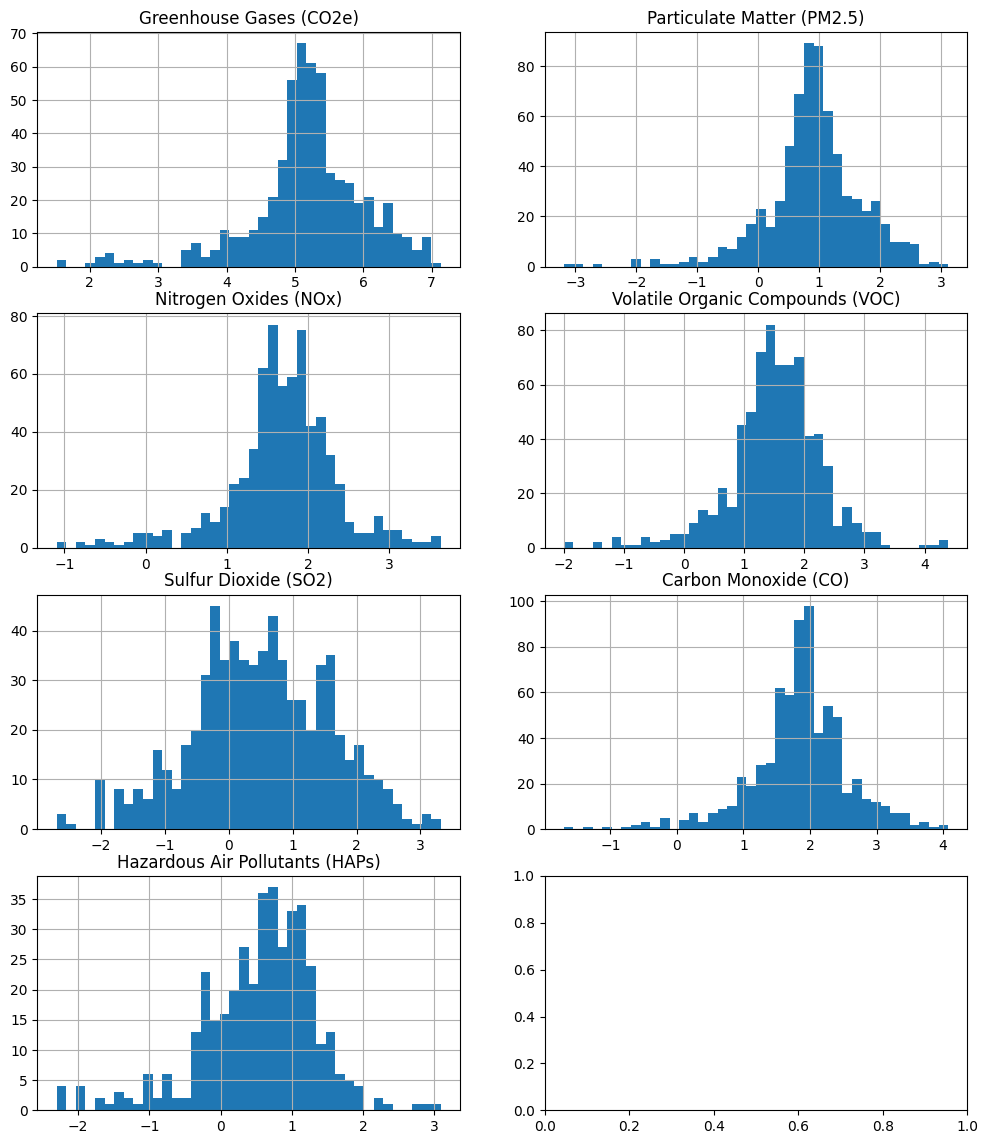

In [41]:
# NOTE: this only includes positive values (most but not all of them)
n = len(emission_cols)
fig, axes = plt.subplots(nrows=round(n/2+0.4), ncols=2, figsize=(12, n*2))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].replace(0,np.nan).transform(np.log10).hist(bins=40, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)

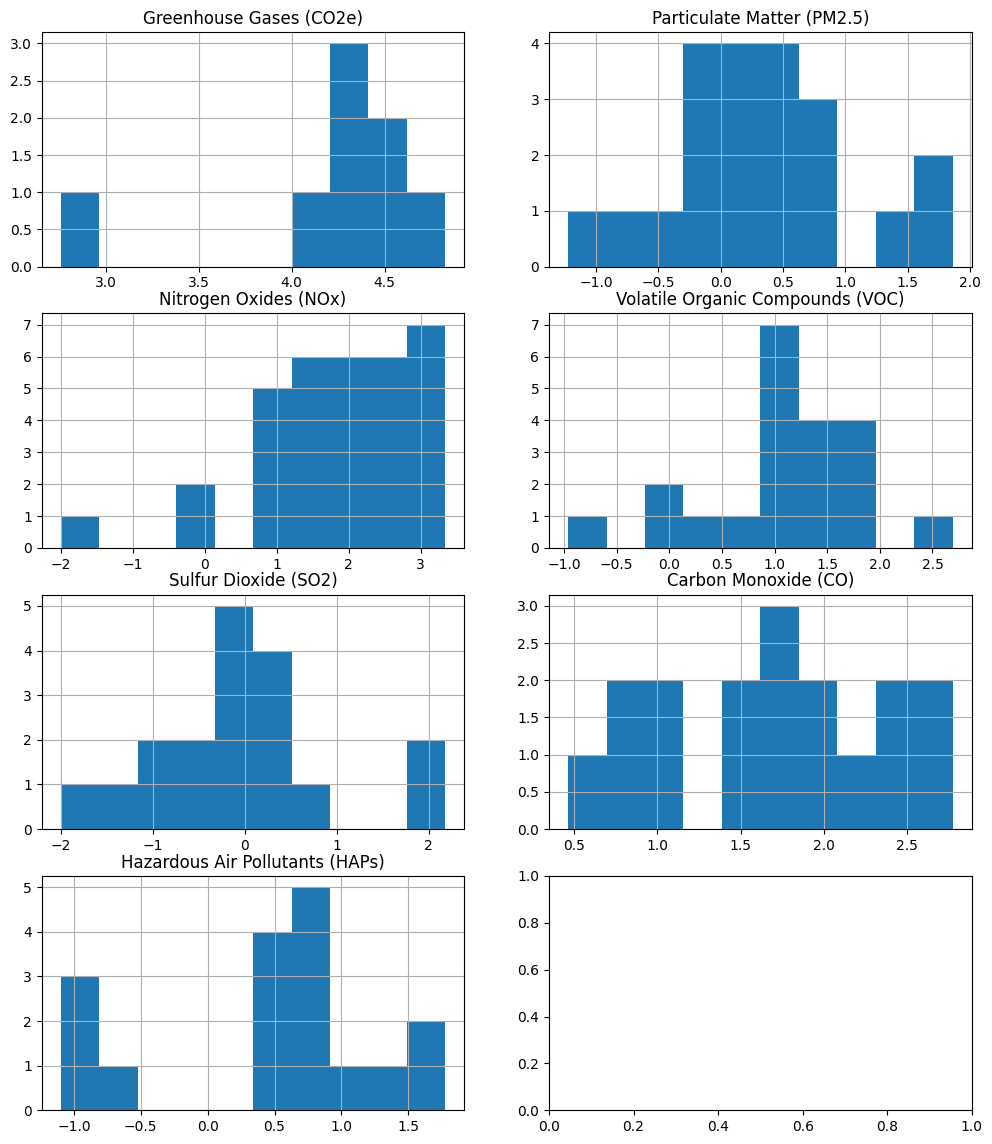

In [42]:
# Negative values only
n = len(emission_cols)
fig, axes = plt.subplots(nrows=round(n/2+0.4), ncols=2, figsize=(12, n*2))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].mul(-1).replace(0,np.nan).transform(np.log10).hist(bins=10, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)

#### IDs
There are lots of ID columns, but I only care about Facility IDs and Air Construction IDs

In [43]:
# defined way up near the top
id_cols # string dtype only

['Air Construction (ID)',
 'Air Operating (ID)',
 'NGA (ID)',
 'Other Permits (ID)']

In [45]:
# they all look in the same range
proj['Facility (ID)'].describe()

count     936.000000
mean     2748.489316
std      2121.209949
min       739.000000
25%       916.750000
50%      1085.500000
75%      4884.000000
max      6407.000000
Name: Facility (ID), dtype: float64

In [46]:
air_const_ids = proj['Air Construction (ID)'].str.split(',', expand=True)
for col in air_const_ids.columns:
    air_const_ids.loc[:, col] = pd.to_numeric(air_const_ids.loc[:, col], errors='coerce')

air_const_ids.head()

,0,1,2,3,4,5
0,1573.0,1574.0,4137.0,4826.0,NaN,NaN
1,2079.0,NaN,NaN,NaN,NaN,NaN
2,2361.0,NaN,NaN,NaN,NaN,NaN
3,2181.0,2182.0,4266.0,NaN,NaN,NaN
4,1578.0,NaN,NaN,NaN,NaN,NaN


In [47]:
# they all look in the same range
air_const_ids.describe()

,0,1,2,3,4,5
count,682.000000,165.000000,64.000000,23.000000,9.000000,3.000000
mean,3198.800587,3667.684848,3913.921875,3797.347826,3516.777778,2676.666667
std,1577.222154,1596.706549,1546.655237,1715.133857,1634.694068,1272.219452
min,1573.000000,1574.000000,1620.000000,1621.000000,1622.000000,1623.000000
25%,1950.250000,2051.000000,2183.500000,2159.000000,2192.000000,1970.000000
50%,2285.500000,3762.000000,4181.500000,4242.000000,3604.000000,2317.000000
75%,4637.500000,4877.000000,5022.000000,5061.500000,4243.000000,3203.500000
max,6386.000000,6321.000000,6392.000000,6310.000000,6123.000000,4090.000000


#### Project Cost
Check uniformity at the same time: should be in millions of dollars. Check vs thousands or single dollars.

<AxesSubplot: >

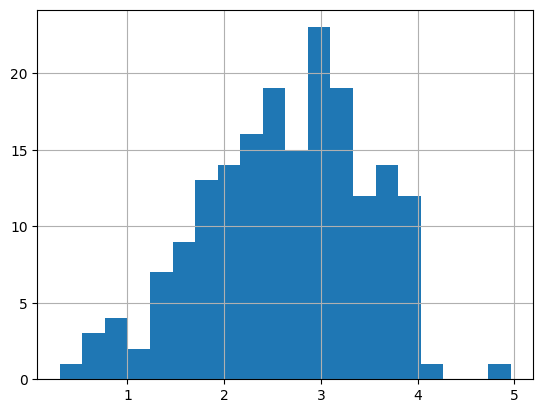

In [49]:
proj['Project Cost (million $)'].transform(np.log10).hist(bins=20)

In [51]:
# Yes, costs are generally in millions. Gron Fuels is off by a factor of 10.
pd.set_option("display.max_colwidth", 0)
proj.loc[
    proj["Project Cost (million $)"].nlargest(5).index,
    ["name", "Project Cost (million $)", "Project Description"],
]

,name,Project Cost (million $),Project Description
659,Gron Fuels' Renewable Fuels Plant - Initial Construction,92000.0,"Construction of a new plant that would convert animal fats and used cooking oils into renewable diesel and naphtha fuels. The project would include a new pretreatment facility capable of processing 60,000 barrels of renewable feedstock every day, as well as a new hydrogen plant capable of producing 150 million standard cubic feet of hydrogen gas every day, and a new wastewater treatment plant."
112,Driftwood LNG - Initial Construction,14500.0,Construction of a new LNG terminal with five liquefaction trains. The terminal will have the capacity to process 27.6 million metric tons of LNG per year for export.
930,Louisiana Offshore CO2 Hub - Initial Construction,10575.0,Initial construction and testing of the proposed sequestration hub.
54,"Cameron LNG, Trains 1-4",10000.0,"Construction of a new liquefied natural gas export terminal next to the existing Cameron LNG Import Terminal. Phase I of the project included three liquefaction trains (Trains 1, 2, and 3), each capable of processing up to 5 million metric tons of LNG per year. Originally, Phase II of the project included two additional liquefaction trains (Trains 4 and 5) that would have expanded Cameron LNG’s total export capacity to nearly 25 million metric tons of LNG per year (approximately 3.53 billion cubic feet per day). In June of 2022, Cameron LNG proposed to remove Train 5 from the original project design and only build Train 4, which would increase export capacity by 6.75 million metric tons of LNG per year, for a revised total of 21.7 million metric tons per year."
282,"GCGV Complex - Ethylene Plant, MEG Plant, LDPE Plant",10000.0,"Construction of a new organic chemicals manufacturing complex, which includes: an ethylene plant, a monoethylene glycol plant, two linear low density polyethylene plants, and supporting logistical and utility infrastructure."


#### Jobs
Skipping for now becuase I need to make a parser first.

### Uniqueness Validation
Check the `id` field

In [52]:
proj['id'].duplicated().sum()

0

### Set Membership Validation
* classification
* industry sector
* project type
* operating status

#### Classification
Doesn't look like any erroneous categories to me.

In [53]:
proj['Classification'].value_counts()

New           487
Expansion     417
Conversion    22 
Restart       10 
Name: Classification, dtype: Int64

#### Industry Sector
A few multi-valued items. Simplify by picking the first one.

In [54]:
proj['Industry Sector'].value_counts()

Natural Gas                                                  377
Petrochemicals and Plastics                                  260
Oil                                                          102
Other                                                        74 
Liquefied Natural Gas                                        51 
Synthetic Fertilizers                                        48 
Synthetic Fertilizers, Other                                 5  
Oil, Natural Gas                                             3  
Synthetic Fertilizers, Other, Petrochemicals and Plastics    2  
Other, Petrochemicals and Plastics, Synthetic Fertilizers    2  
Oil, Other                                                   2  
Other, Petrochemicals and Plastics                           2  
Petrochemicals and Plastics, Oil                             1  
Other, Oil                                                   1  
Petrochemicals and Plastics, Other                           1  
Synthetic Fertilizers, Pe

In [57]:
# split and combine value counts
proj['Industry Sector'].str.split(',', expand=True).stack().str.strip().value_counts()

Natural Gas                    381
Petrochemicals and Plastics    272
Oil                            112
Other                          92 
Synthetic Fertilizers          59 
Liquefied Natural Gas          52 
dtype: Int64

#### Project Type
This column has a fair number of multivalued array entries. But the categories themselves look consistent -- no mis-spellings, etc.

In [55]:
proj['Project Type'].value_counts()

Compressor Station                                                                                                   288
Gas Processing Plant                                                                                                 82 
Refinery                                                                                                             58 
Liquefied Natural Gas Terminal or Liquefaction Plant                                                                 45 
Chemical Recycling Plant                                                                                             40 
Natural Gas Liquids Fractionator                                                                                     37 
Other Organic Chemicals                                                                                              35 
Ethylene Cracker                                                                                                     31 
Crude Oil Terminal              

In [56]:
# split and combine value counts
proj['Project Type'].str.split(',', expand=True).stack().str.strip().value_counts()

Compressor Station                                      290
Gas Processing Plant                                    105
Refinery                                                61 
Natural Gas Liquids Fractionator                        57 
Carbon Capture Use and Storage                          53 
Liquefied Natural Gas Terminal or Liquefaction Plant    48 
Other Organic Chemicals                                 43 
Chemical Recycling Plant                                40 
Ethylene Cracker                                        39 
Fertilizer Plant                                        32 
Crude Oil Terminal                                      31 
Plastic Resin Manufacturing                             31 
Renewable Diesel or Gasoline Refinery                   26 
Green Hydrogen                                          23 
Blue Ammonia                                            23 
Methanol Plant                                          23 
Blue Hydrogen                           

#### Product Type
This column has a fair number of multivalued array entries. But the categories themselves look consistent -- no mis-spellings, etc.

In [66]:
proj['Product Type'].value_counts()

Ethylene                                                                               28
Propylene                                                                              12
Ammonia                                                                                10
Polyethylene                                                                           9 
Ammonia, Urea                                                                          5 
Polyethylene Terephthalate (PET)                                                       5 
Blue Ammonia                                                                           4 
Blue Ammonia, Ammonia Fuel                                                             4 
Specialty Polymers                                                                     3 
Blue Hydrogen, Ammonia Fuel, Blue Ammonia                                              2 
Polypropylene                                                                          2 
Ammonia Fu

In [67]:
# split and combine value counts
proj['Product Type'].str.split(',', expand=True).stack().str.strip().value_counts()

Ethylene                            38
Ammonia                             25
Blue Ammonia                        20
Ammonia Fuel                        18
Urea                                16
Propylene                           15
Polyethylene                        11
Blue Hydrogen                       10
Nitric Acid                         9 
Polyethylene Terephthalate (PET)    6 
Green Ammonia                       6 
Urea Ammonium Nitrate (UAN)         6 
HDPE                                5 
Diesel Exhaust Fluid (DEF)          5 
LDPE                                5 
MEG                                 4 
Polypropylene                       4 
Vinyl Chloride Monomer (VCM)        4 
1-Hexene                            3 
Carbon Black                        3 
Specialty Polymers                  3 
Polyvinyl chloride (PVC)            3 
Hydrochloric Acid (HCl)             2 
Ethylene Glycol                     2 
Terephthalic Acid (PTA)             2 
MMA                      

#### Operating Status
Just need to replace "Unknown" with Null

In [58]:
proj['Operating Status'].value_counts()

Operating              422
Pre-construction       209
Announced              162
Under construction     54 
Canceled               39 
Partially operating    27 
On hold                21 
Commissioning          2  
Unknown                1  
Name: Operating Status, dtype: Int64

### Type Validation
Already did this while doing range validation, but `Hazardous Air Pollutants (HAPs)`and `Project Cost` require parsing duplicative csv array values in what should be a numeric column. Also, `Number of Jobs Promised` needs parsing into two columns: permanent and temporary jobs.

#### Completion Year
I started converting this to numeric, but would have to model multi-valued items. I think the benefit (sorting, quantitative analysis) is small relative to 1) the cost it will take to communicate the modeling and 2) actually doing the modelling. I think we have other fields we would filter on first.

<AxesSubplot: >

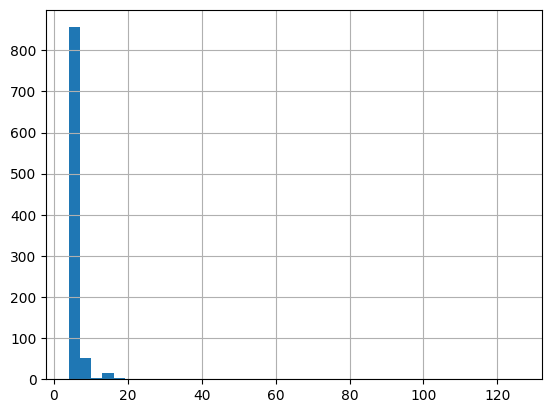

In [59]:
proj['Actual or Expected Completion Year'].str.len().hist(bins=40)

In [60]:
proj['Actual or Expected Completion Year'].str.len().nlargest(8)

553    126
328    79 
291    19 
611    19 
54     14 
91     14 
147    14 
201    14 
Name: Actual or Expected Completion Year, dtype: Int64

In [61]:
proj.loc[
    proj["Actual or Expected Completion Year"].str.len().nlargest(8).index,
    "Actual or Expected Completion Year",
]

553    Train 5 began operating in 2019. Commissioning of Train 6 began in November 2021, with full completion expected in early 2022.
328    Trains 1 and 2 began operating in 2016. Trains 3 and 4 began operating in 2017.                                               
291    2014/2017/2019/2021                                                                                                           
611    2015/2018/2020/2022                                                                                                           
54     2019/2020/2026                                                                                                                
91     2018/2019/2021                                                                                                                
147    2029/2030/2031                                                                                                                
201    2018/2020/2021                                         

### Cross-Field Validation
None really needed. I could check that the date columns are in a logical order (modified > created, for example) but I'm not planning to really use those columns. So I skipped it.

In [62]:
proj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           938 non-null    Int32  
 1   name                                         938 non-null    string 
 2   created_on                                   938 non-null    string 
 3   modified_on                                  938 non-null    string 
 4   Facility (ID)                                936 non-null    float64
 5   Facility                                     936 non-null    string 
 6   CCS (ID)                                     19 non-null     float64
 7   CCS                                          60 non-null     string 
 8   Project Description                          934 non-null    string 
 9   Classification                               936 non-null    string 
 10  In

In [63]:
from dbcp.transform.eip_infrastructure import projects_transform

In [68]:
trans = projects_transform(extract(path)['eip_projects'])

In [69]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 44 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   project_id                                     938 non-null    Int32         
 1   name                                           938 non-null    string        
 2   raw_created_on                                 938 non-null    string        
 3   raw_modified_on                                938 non-null    string        
 4   raw_facility_id                                936 non-null    float64       
 5   raw_ccs_id                                     19 non-null     float64       
 6   raw_is_ccs                                     60 non-null     string        
 7   project_description                            934 non-null    string        
 8   classification                                 936 non-null 